# DSCI445 Term Project - Bank Account Fraud Detection
### Jakob Wickham, Nick Brady, Noah Sturgeon

## 1. Introduction

In [ ]:
#pdf making note = remove this cell
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as skim
import xgboost as xgb
import kagglehub
import seaborn as sns
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
#pdf making note = hide this cell
# Only run if you want to locally have the dataset on your machine
path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

data: pd.DataFrame = pd.read_csv(f"{path}/Base.csv")

&nbsp;&nbsp;&nbsp;&nbsp;The Bank Account Fraud NeurIPS 2022 datasets (called BAF for short) are a suite of synthetic datasets meant to evaluate machine learning methods. 
BAF was generated with a fraud label, a boolean value called fraud_bool, which is the response on which machine learning methods can be tested on.

&nbsp;&nbsp;&nbsp;&nbsp;Our goal in this project is to work with various machine learning methods to get the highest recall (how many fraudulent transactions are successfully identified) possible, while locking our false positive rate (how many valid transactions are misidentified) at 5% or lower. The reason for using recall, as opposed to accuracy, is due to the nature of the dataset. There is far less fraud than legitimate transactions, and so aiming for accuracy will inherently create a model that is useless at detecting fraud.

## 2. Data Processing and Exploration 

{Should Talk about the Size of the Data and Number of columns with Code Here }

&nbsp;&nbsp;&nbsp;&nbsp;The dataset has 1 million bank account instances with 31 features, and the fraud_bool response for each instance.

In [27]:
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


### Contents of the dataset:

#### Categorical
- **`payment_type`** - Credit payment plan type (5 types: AA, AB, AC, AD, AE)
- **`employment_status`** - Employment status of the applicant (7 types: CA - CG)
- **`housing_status`** - Residential status of the applicant (7 types: BA - BG)
- **`source`** - Online source of the application; INTERNET or TELEAPP
- **`device_os`** - Operating system of the device (e.g., Windows, macOS, Linux, X11, other)

#### Numeric
- **`income`** - Annual income of the applicant in quantiles; x ∈ [0.1, 0.9]
- **`name_email_similarity`** - Similarity between email and applicant’s name; ranges from [0, 1]
- **`prev_address_months_count`** - Months at previous address; ranges from [-1, 380] (-1 = missing value)
- **`current_address_months_count`** - Months at current address; ranges from [-1, 429] (-1 = missing value)
- **`customer_age`** - Age in years rounded to decade; ranges from [10, 90] years
- **`days_since_request`** - Days since application was submitted; ranges from [0, 79] days
- **`intended_balcon_amount`** - Initial amount transferred; ranges from [-16, 114] (negatives = missing value)
- **`zip_count_4w`** - Applications in the same zip code in the last 4 weeks; ranges from [1, 6830]
- **`velocity_6h`** - Applications per hour in the last 6 hours; ranges from [-175, 16818]
- **`velocity_24h`** - Applications per hour in the last 24 hours; ranges from [1297, 9586]
- **`velocity_4w`** - Applications per hour in the last 4 weeks; ranges from [2825, 7020]
- **`bank_branch_count_8w`** - Applications at the bank branch in the last 8 weeks; ranges from [0, 2404]
- **`date_of_birth_distinct_emails_4w`** - Emails for applicants with the same birthdate in the last 4 weeks; ranges from [0, 39]
- **`credit_risk_score`** - Internal risk score; ranges from [-191, 389]
- **`bank_months_count`** - Age of the previous account in months; ranges from [-1, 32] (-1 = missing value)
- **`proposed_credit_limit`** - Proposed credit limit; ranges from [200, 2000]
- **`session_length_in_minutes`** - User session length on the banking website; ranges from [-1, 107] (-1 = missing value)
- **`device_distinct_emails_8w`** - Distinct emails associated with the device in the last 8 weeks; ranges from [-1, 2] (-1 = missing value)
- **`device_fraud_count`** - Number of fraudulent applications with used device.[0, 1]
- **`month`** - Month where the application was made. [0, 7]


#### Binary
- **`fraud_bool`** - Target variable; 0 if legit, 1 if fraud
- **`email_is_free`** - Whether email domain is free 
- **`phone_home_valid`** - Validity of provided home phone number 
- **`phone_mobile_valid`** - Validity of provided mobile phone number 
- **`has_other_cards`** - Whether the applicant has other cards with the bank 
- **`foreign_request`** - If the request origin country differs from the bank’s country 
- **`keep_alive_session`** - Whether the user enabled "remember me" 

### Exploratory Data Analysis

#### Numeric Exploration

In [39]:
numeric_features = [
    'income', 
    'name_email_similarity', 
    'prev_address_months_count', 
    'current_address_months_count',
    'customer_age', 
    'days_since_request', 
    'intended_balcon_amount', 
    'zip_count_4w', 
    'velocity_6h',
    'velocity_24h', 
    'velocity_4w', 
    'bank_branch_count_8w', 
    'date_of_birth_distinct_emails_4w',
    'credit_risk_score', 
    'bank_months_count', 
    'proposed_credit_limit', 
    'session_length_in_minutes',
    'device_distinct_emails_8w',
    'device_fraud_count',
    'month'
]

numeric_summary = data[numeric_features].describe()

numeric_summary

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,4769.781965,4856.324016,184.361849,9.503544,130.989595,10.839303,515.851010,7.544940,1.018312,0.0,3.288674
std,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,1479.212612,919.843934,459.625329,5.033792,69.681812,12.116875,487.559902,8.033106,0.180761,0.0,2.209994
min,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1300.307314,2825.748405,0.000000,0.000000,-170.000000,-1.000000,190.000000,-1.000000,-1.000000,0.0,0.000000
25%,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,3593.179135,4268.368423,1.000000,6.000000,83.000000,-1.000000,200.000000,3.103053,1.000000,0.0,1.000000
50%,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,4749.921161,4913.436941,9.000000,9.000000,122.000000,5.000000,200.000000,5.114321,1.000000,0.0,3.000000
75%,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,5752.574191,5488.083356,25.000000,13.000000,178.000000,25.000000,500.000000,8.866131,1.000000,0.0,5.000000
max,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,9506.896596,6994.764201,2385.000000,39.000000,389.000000,32.000000,2100.000000,85.899143,2.000000,0.0,7.000000


In [7]:
numeric_missing_value_columns = [
    'prev_address_months_count',
    'current_address_months_count',
    'intended_balcon_amount', 
    'bank_months_count', 
    'session_length_in_minutes', 
    'device_distinct_emails_8w'
]

missing_data_summary = pd.DataFrame({
    'Missing Data Count': [(data[col] < 0).sum() for col in numeric_missing_value_columns],
    'Percentage Missing': [(data[col] < 0).mean() * 100 for col in numeric_missing_value_columns]
}, index=numeric_missing_value_columns)

print(missing_data_summary)

                              Missing Data Count  Percentage Missing
prev_address_months_count                 712920             71.2920
current_address_months_count                4254              0.4254
intended_balcon_amount                    742523             74.2523
bank_months_count                         253635             25.3635
session_length_in_minutes                   2015              0.2015
device_distinct_emails_8w                    359              0.0359


In [15]:
non_negative_rows = data[(data[numeric_missing_value_columns] >= 0).all(axis=1)]
any_negative_rows = data[(data[numeric_missing_value_columns] < 0).any(axis=1)]

non_negative_counts = non_negative_rows['fraud_bool'].value_counts()
any_negative_counts = any_negative_rows['fraud_bool'].value_counts()

fraud_counts = pd.DataFrame({
    'Non-Negative Values Count': [non_negative_counts.get(0, 0), non_negative_counts.get(1, 0)],
    'Any Negative Values Count': [any_negative_counts.get(0, 0), any_negative_counts.get(1, 0)]
}, index=['Non-Fraud (0)', 'Fraud (1)'])

print(fraud_counts)

               Non-Negative Values Count  Any Negative Values Count
Non-Fraud (0)                      64690                     924281
Fraud (1)                             80                      10949


In [ ]:
device_fraud_counts = data['device_fraud_count'].value_counts()

device_fraud_counts_df = pd.DataFrame({
    'Device Fraud Count': device_fraud_counts.index,
    'Count': device_fraud_counts.values
})

print(device_fraud_counts_df)

   Device Fraud Count    Count
0                   0  1000000


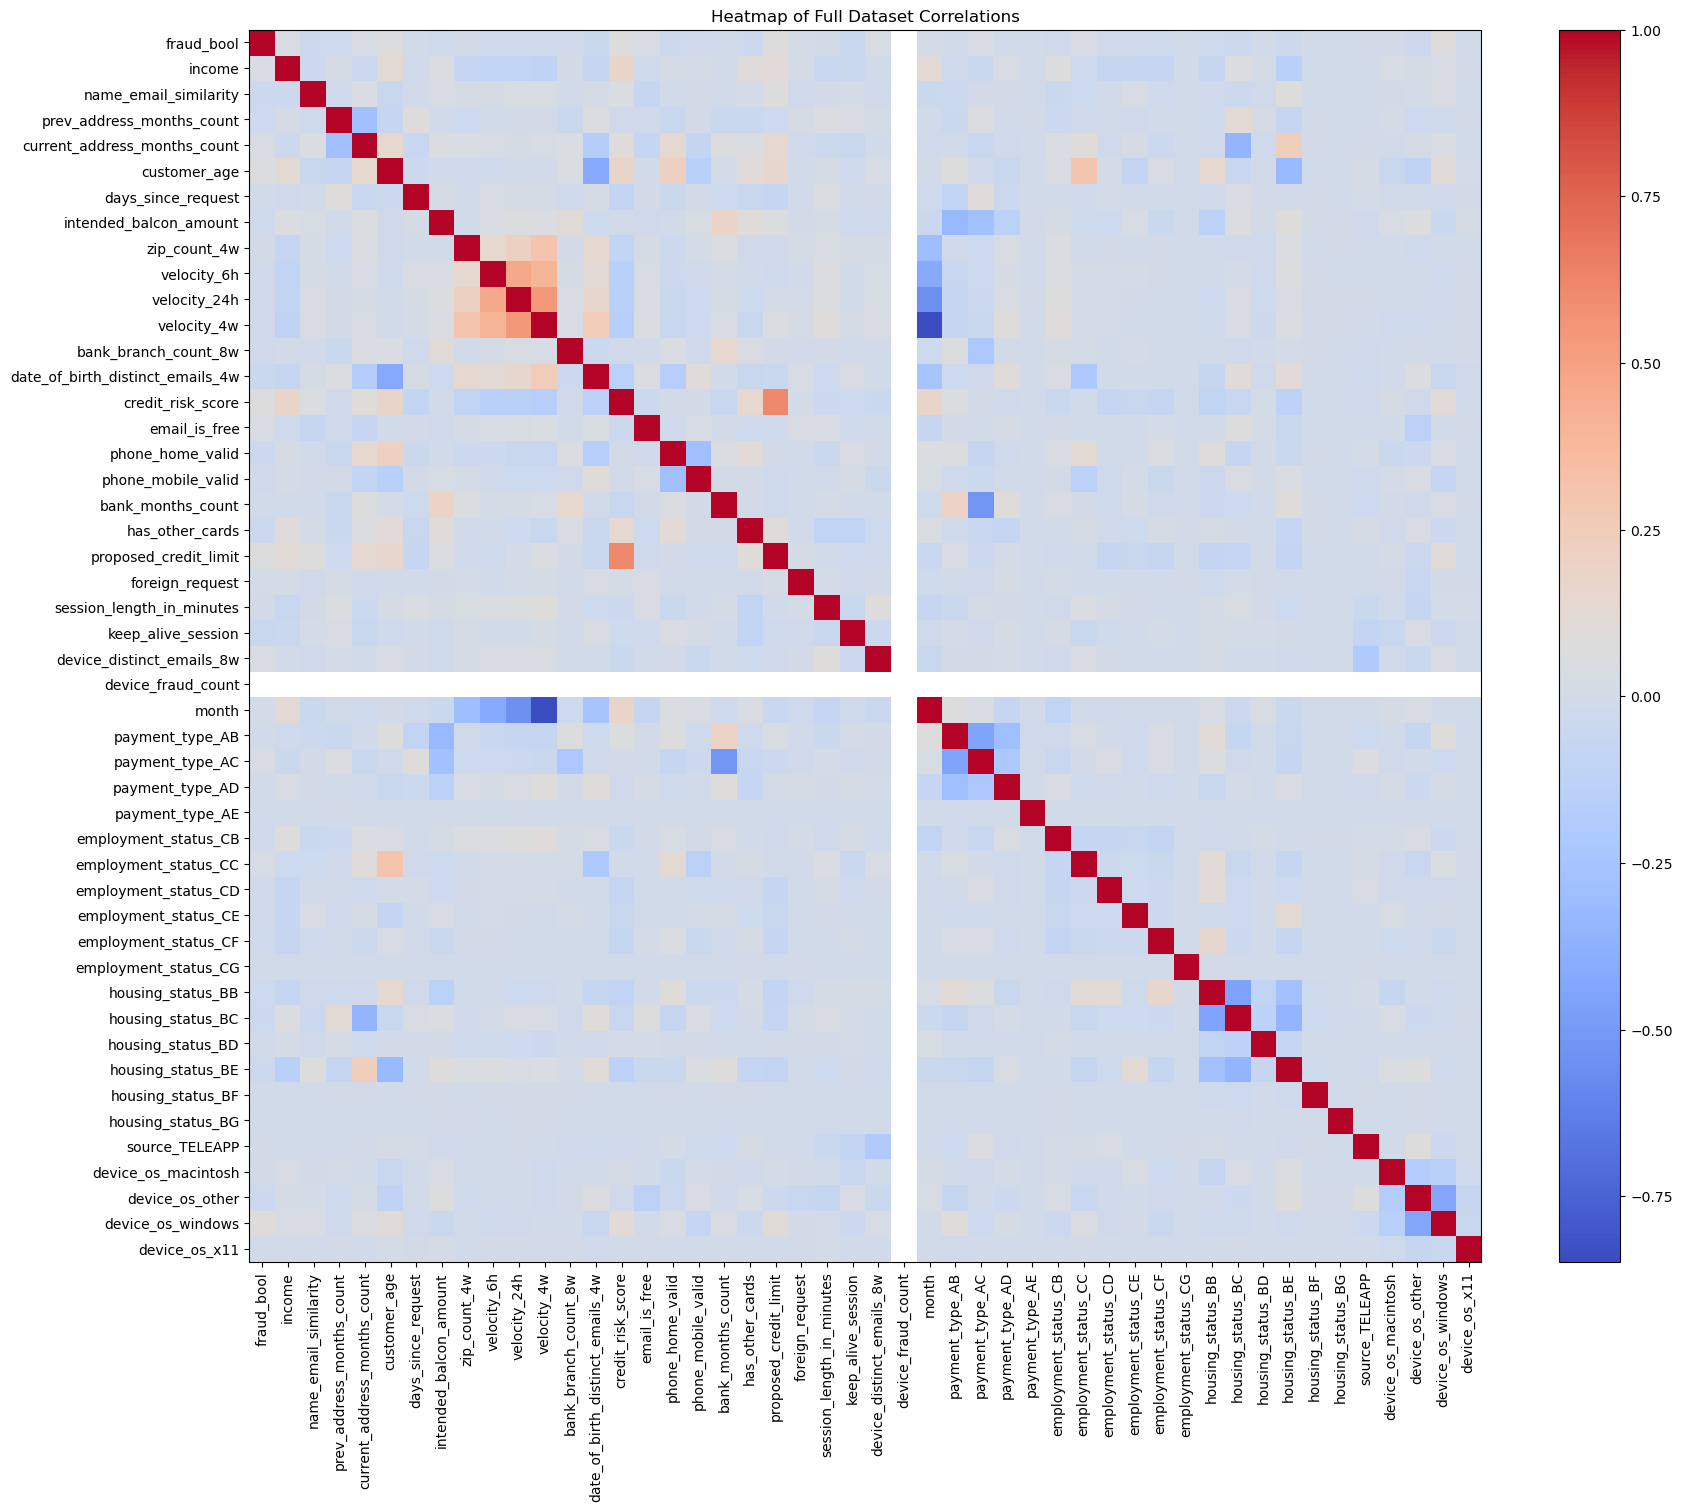

In [ ]:

df_encoded = pd.get_dummies(data, drop_first=True)


correlation_matrix = df_encoded.corr()


plt.figure(figsize=(20, 16))  
plt.imshow(correlation_matrix, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Heatmap of Full Dataset Correlations")
plt.show()

#### Categorical Exploration

In [6]:
categorical_features = [
    'payment_type',
    'employment_status',
    'housing_status',
    'source',
    'device_os'
]

categorical_summary = data[categorical_features].describe()

categorical_summary

,payment_type,employment_status,housing_status,source,device_os
count,1000000,1000000,1000000,1000000,1000000
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,other
freq,370554,730252,372143,992952,342728


In [141]:
payment_type_counts = pd.DataFrame(data.groupby(data['payment_type'])['fraud_bool'].value_counts())
payment_type_counts['percentage'] = payment_type_counts.groupby(['payment_type', 'fraud_bool']).transform(
    lambda x: x / payment_type_counts.groupby('payment_type').sum()['count'])

print(payment_type_counts)

payment_type_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['payment_type'].value_counts())
payment_type_counts_2['percentage'] = payment_type_counts_2.groupby(['fraud_bool', 'payment_type']).transform(
    lambda x: x / payment_type_counts_2.groupby('fraud_bool').sum()['count'])

print(payment_type_counts_2)

                          count  percentage
payment_type fraud_bool                    
AA           0           256885    0.994718
             1             1364    0.005282
AB           0           366385    0.988749
             1             4169    0.011251
AC           0           247862    0.983302
             1             4209    0.016698
AD           0           117551    0.989178
             1             1286    0.010822
AE           0              288    0.996540
             1                1    0.003460
                          count  percentage
fraud_bool payment_type                    
0          AB            366385    0.370471
           AA            256885    0.259750
           AC            247862    0.250626
           AD            117551    0.118862
           AE               288    0.000291
1          AC              4209    0.381630
           AB              4169    0.378003
           AA              1364    0.123674
           AD              1286 

In [103]:
employment_status_counts = pd.DataFrame(data.groupby(data['employment_status'])['fraud_bool'].value_counts())
employment_status_counts['percentage'] = employment_status_counts.groupby(['employment_status', 'fraud_bool']).transform(
    lambda x: x / employment_status_counts.groupby('employment_status').sum()['count'])

print(employment_status_counts)

employment_status_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['employment_status'].value_counts())
employment_status_counts_2['percentage'] = employment_status_counts_2.groupby(['fraud_bool', 'employment_status']).transform(
    lambda x: x / employment_status_counts_2.groupby('fraud_bool').sum()['count'])

print(employment_status_counts_2)

                               count  percentage
employment_status fraud_bool                    
CA                0           721353    0.987814
                  1             8899    0.012186
CB                0           137335    0.993109
                  1              953    0.006891
CC                0            36826    0.975316
                  1              932    0.024684
CD                0            26422    0.996230
                  1              100    0.003770
CE                0            22640    0.997664
                  1               53    0.002336
CF                0            43949    0.998070
                  1               85    0.001930
CG                0              446    0.984547
                  1                7    0.015453
                               count  percentage
fraud_bool employment_status                    
0          CA                 721353    0.729398
           CB                 137335    0.138867
           CF       

In [104]:
housing_status_counts = pd.DataFrame(data.groupby(data['housing_status'])['fraud_bool'].value_counts())
housing_status_counts['percentage'] = housing_status_counts.groupby(['housing_status', 'fraud_bool']).transform(
    lambda x: x / housing_status_counts.groupby('housing_status').sum()['count'])

print(housing_status_counts)

housing_status_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['housing_status'].value_counts())
housing_status_counts_2['percentage'] = housing_status_counts_2.groupby(['fraud_bool', 'housing_status']).transform(
    lambda x: x / housing_status_counts_2.groupby('fraud_bool').sum()['count'])

print(housing_status_counts_2)

                            count  percentage
housing_status fraud_bool                    
BA             0           163318    0.962534
               1             6357    0.037466
BB             0           259397    0.993992
               1             1568    0.006008
BC             0           369855    0.993852
               1             2288    0.006148
BD             0            25935    0.991361
               1              226    0.008639
BE             0           168553    0.996559
               1              582    0.003441
BF             0             1662    0.995806
               1                7    0.004194
BG             0              251    0.996032
               1                1    0.003968
                            count  percentage
fraud_bool housing_status                    
0          BC              369855    0.373980
           BB              259397    0.262290
           BE              168553    0.170433
           BA              163318 

In [105]:
source_counts = pd.DataFrame(data.groupby(data['source'])['fraud_bool'].value_counts())
source_counts['percentage'] = source_counts.groupby(['source', 'fraud_bool']).transform(
    lambda x: x / source_counts.groupby('source').sum()['count'])

print(source_counts)

source_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['source'].value_counts())
source_counts_2['percentage'] = source_counts_2.groupby(['fraud_bool', 'source']).transform(
    lambda x: x / source_counts_2.groupby('fraud_bool').sum()['count'])

print(source_counts_2)

                      count  percentage
source   fraud_bool                    
INTERNET 0           982035    0.989006
         1            10917    0.010994
TELEAPP  0             6936    0.984109
         1              112    0.015891
                      count  percentage
fraud_bool source                      
0          INTERNET  982035    0.992987
           TELEAPP     6936    0.007013
1          INTERNET   10917    0.989845
           TELEAPP      112    0.010155


In [106]:
device_os_counts = pd.DataFrame(data.groupby(data['device_os'])['fraud_bool'].value_counts())
device_os_counts['percentage'] = device_os_counts.groupby(['device_os', 'fraud_bool']).transform(
    lambda x: x / device_os_counts.groupby('device_os').sum()['count'])

print(device_os_counts)

device_os_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['device_os'].value_counts())
device_os_counts_2['percentage'] = device_os_counts_2.groupby(['fraud_bool', 'device_os']).transform(
    lambda x: x / device_os_counts_2.groupby('fraud_bool').sum()['count'])

print(device_os_counts_2)

                       count  percentage
device_os fraud_bool                    
linux     0           330997    0.994845
          1             1715    0.005155
macintosh 0            53074    0.986029
          1              752    0.013971
other     0           340754    0.994240
          1             1974    0.005760
windows   0           256999    0.975306
          1             6507    0.024694
x11       0             7147    0.988794
          1               81    0.011206
                       count  percentage
fraud_bool device_os                    
0          other      340754    0.344554
           linux      330997    0.334688
           windows    256999    0.259865
           macintosh   53074    0.053666
           x11          7147    0.007227
1          windows      6507    0.589990
           other        1974    0.178983
           linux        1715    0.155499
           macintosh     752    0.068184
           x11            81    0.007344


#### Binary Exploration

In [127]:
binary_features = [
    'email_is_free',
    'phone_home_valid',
    'phone_mobile_valid',
    'has_other_cards',
    'foreign_request',
    'keep_alive_session'
]

binary_summary = data[binary_features].astype(bool).describe()

binary_summary

,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,2,2,2,2,2,2
top,True,False,True,False,False,True
freq,529886,582923,889676,777012,974758,576947


                           count  percentage
email_is_free fraud_bool                    
0             0           466376    0.992049
              1             3738    0.007951
1             0           522595    0.986240
              1             7291    0.013760
                           count  percentage
fraud_bool email_is_free                    
0          1              522595    0.528423
           0              466376    0.471577
1          1                7291    0.661075
           0                3738    0.338925


<Axes: xlabel='fraud_bool', ylabel='percentage'>

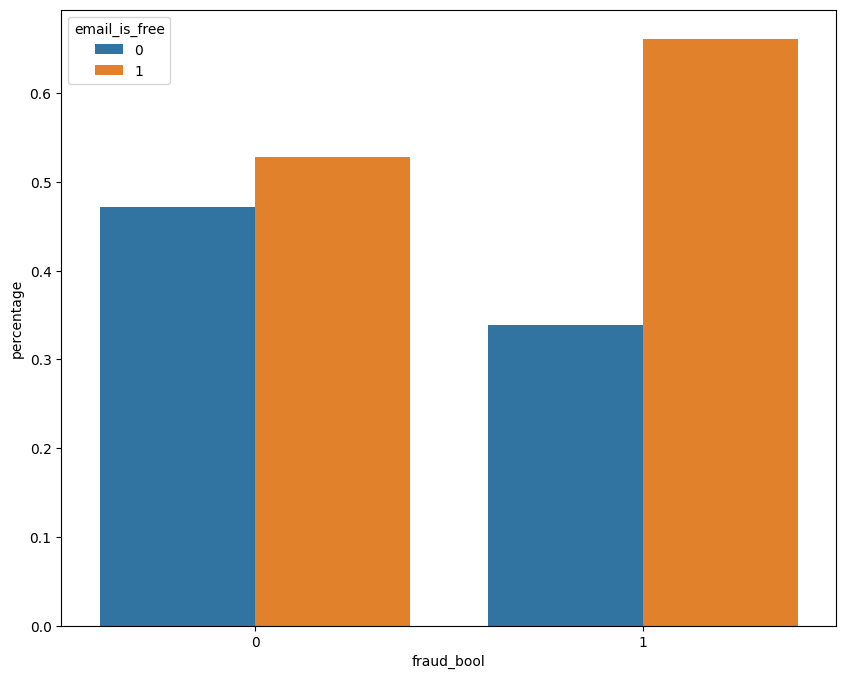

In [133]:
email_is_free_counts = pd.DataFrame(data.groupby(data['email_is_free'])['fraud_bool'].value_counts())
email_is_free_counts['percentage'] = email_is_free_counts.groupby(['email_is_free', 'fraud_bool']).transform(
    lambda x: x / email_is_free_counts.groupby('email_is_free').sum()['count'])

print(email_is_free_counts)

email_is_free_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['email_is_free'].value_counts())
email_is_free_counts_2['percentage'] = email_is_free_counts_2.groupby(['fraud_bool', 'email_is_free']).transform(
    lambda x: x / email_is_free_counts_2.groupby('fraud_bool').sum()['count'])

print(email_is_free_counts_2)

plt.figure(figsize=(10, 8))  
sns.barplot(x="fraud_bool", y="percentage", hue="email_is_free", data=email_is_free_counts_2)

                              count  percentage
phone_home_valid fraud_bool                    
0                0           574685    0.985868
                 1             8238    0.014132
1                0           414286    0.993308
                 1             2791    0.006692
                              count  percentage
fraud_bool phone_home_valid                    
0          0                 574685    0.581094
           1                 414286    0.418906
1          0                   8238    0.746940
           1                   2791    0.253060


<Axes: xlabel='fraud_bool', ylabel='percentage'>

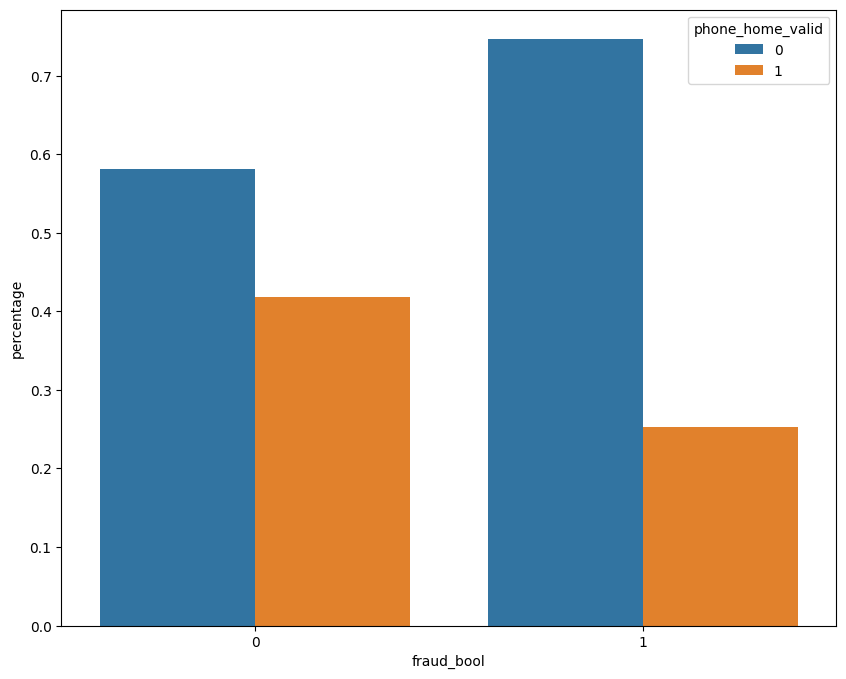

In [135]:
phone_home_valid_counts = pd.DataFrame(data.groupby(data['phone_home_valid'])['fraud_bool'].value_counts())
phone_home_valid_counts['percentage'] = phone_home_valid_counts.groupby(['phone_home_valid', 'fraud_bool']).transform(
    lambda x: x / phone_home_valid_counts.groupby('phone_home_valid').sum()['count'])

print(phone_home_valid_counts)

phone_home_valid_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['phone_home_valid'].value_counts())    
phone_home_valid_counts_2['percentage'] = phone_home_valid_counts_2.groupby(['fraud_bool', 'phone_home_valid']).transform(
    lambda x: x / phone_home_valid_counts_2.groupby('fraud_bool').sum()['count'])

print(phone_home_valid_counts_2)

plt.figure(figsize=(10, 8))  
sns.barplot(x="fraud_bool", y="percentage", hue="phone_home_valid", data=phone_home_valid_counts_2)

                                count  percentage
phone_mobile_valid fraud_bool                    
0                  0           108676    0.985062
                   1             1648    0.014938
1                  0           880295    0.989456
                   1             9381    0.010544
                                count  percentage
fraud_bool phone_mobile_valid                    
0          1                   880295    0.890112
           0                   108676    0.109888
1          1                     9381    0.850576
           0                     1648    0.149424


<Axes: xlabel='fraud_bool', ylabel='percentage'>

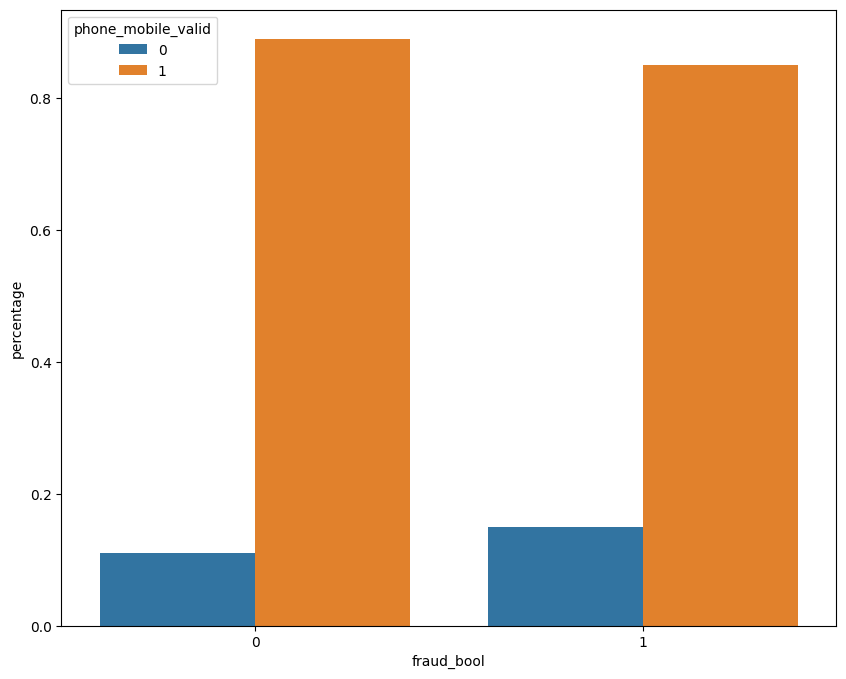

In [136]:
phone_mobile_valid_counts = pd.DataFrame(data.groupby(data['phone_mobile_valid'])['fraud_bool'].value_counts())
phone_mobile_valid_counts['percentage'] = phone_mobile_valid_counts.groupby(['phone_mobile_valid', 'fraud_bool']).transform(
    lambda x: x / phone_mobile_valid_counts.groupby('phone_mobile_valid').sum()['count'])

print(phone_mobile_valid_counts)

phone_mobile_valid_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['phone_mobile_valid'].value_counts())    
phone_mobile_valid_counts_2['percentage'] = phone_mobile_valid_counts_2.groupby(['fraud_bool', 'phone_mobile_valid']).transform(
    lambda x: x / phone_mobile_valid_counts_2.groupby('fraud_bool').sum()['count'])

print(phone_mobile_valid_counts_2)

plt.figure(figsize=(10, 8))  
sns.barplot(x="fraud_bool", y="percentage", hue="phone_mobile_valid", data=phone_mobile_valid_counts_2)

                             count  percentage
has_other_cards fraud_bool                    
0               0           766914    0.987004
                1            10098    0.012996
1               0           222057    0.995825
                1              931    0.004175
                             count  percentage
fraud_bool has_other_cards                    
0          0                766914    0.775467
           1                222057    0.224533
1          0                 10098    0.915586
           1                   931    0.084414


<Axes: xlabel='fraud_bool', ylabel='percentage'>

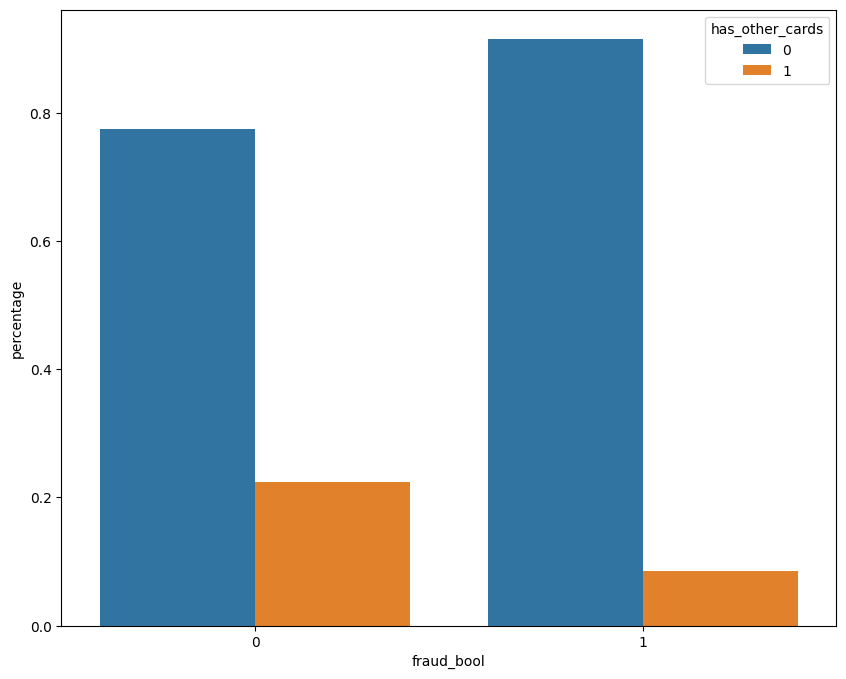

In [137]:
has_other_cards_counts = pd.DataFrame(data.groupby(data['has_other_cards'])['fraud_bool'].value_counts())
has_other_cards_counts['percentage'] = has_other_cards_counts.groupby(['has_other_cards', 'fraud_bool']).transform(
    lambda x: x / has_other_cards_counts.groupby('has_other_cards').sum()['count'])

print(has_other_cards_counts)

has_other_cards_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['has_other_cards'].value_counts())    
has_other_cards_counts_2['percentage'] = has_other_cards_counts_2.groupby(['fraud_bool', 'has_other_cards']).transform(
    lambda x: x / has_other_cards_counts_2.groupby('fraud_bool').sum()['count'])

print(has_other_cards_counts_2)

plt.figure(figsize=(10, 8))  
sns.barplot(x="fraud_bool", y="percentage", hue="has_other_cards", data=has_other_cards_counts_2)

                             count  percentage
foreign_request fraud_bool                    
0               0           964284    0.989255
                1            10474    0.010745
1               0            24687    0.978013
                1              555    0.021987
                             count  percentage
fraud_bool foreign_request                    
0          0                964284    0.975038
           1                 24687    0.024962
1          0                 10474    0.949678
           1                   555    0.050322


<Axes: xlabel='fraud_bool', ylabel='percentage'>

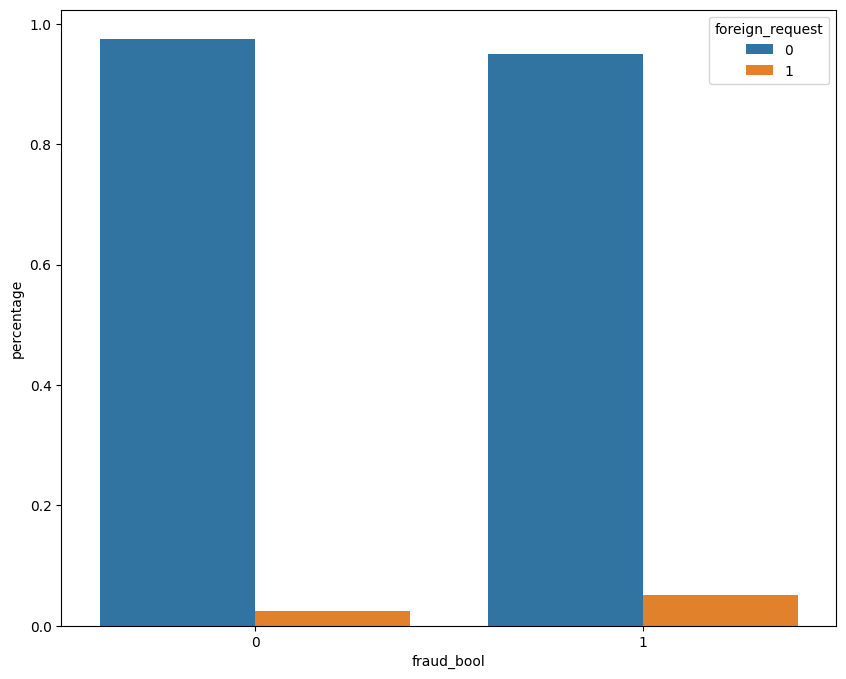

In [139]:
foreign_request_counts = pd.DataFrame(data.groupby(data['foreign_request'])['fraud_bool'].value_counts())
foreign_request_counts['percentage'] = foreign_request_counts.groupby(['foreign_request', 'fraud_bool']).transform(
    lambda x: x / foreign_request_counts.groupby('foreign_request').sum()['count'])

print(foreign_request_counts)

foreign_request_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['foreign_request'].value_counts())    
foreign_request_counts_2['percentage'] = foreign_request_counts_2.groupby(['fraud_bool', 'foreign_request']).transform(
    lambda x: x / foreign_request_counts_2.groupby('fraud_bool').sum()['count'])

print(foreign_request_counts_2)

plt.figure(figsize=(10, 8))
sns.barplot(x="fraud_bool", y="percentage", hue="foreign_request", data=foreign_request_counts_2)

                                count  percentage
keep_alive_session fraud_bool                    
0                  0           415792    0.982837
                   1             7261    0.017163
1                  0           573179    0.993469
                   1             3768    0.006531
                                count  percentage
fraud_bool keep_alive_session                    
0          1                   573179    0.579571
           0                   415792    0.420429
1          0                     7261    0.658355
           1                     3768    0.341645


<Axes: xlabel='fraud_bool', ylabel='percentage'>

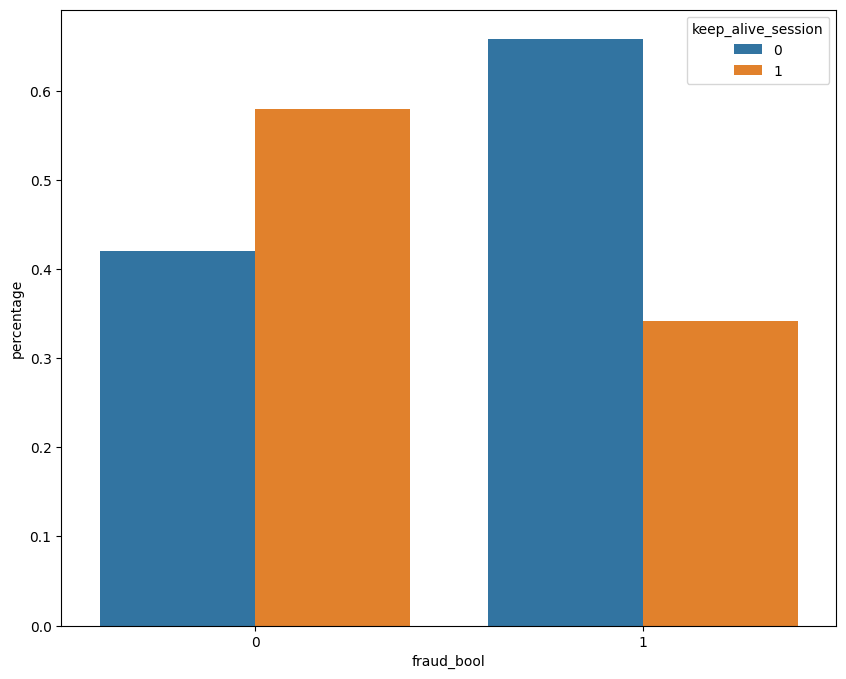

In [140]:
keep_alive_session_counts = pd.DataFrame(data.groupby(data['keep_alive_session'])['fraud_bool'].value_counts())
keep_alive_session_counts['percentage'] = keep_alive_session_counts.groupby(['keep_alive_session', 'fraud_bool']).transform(
    lambda x: x / keep_alive_session_counts.groupby('keep_alive_session').sum()['count'])

print(keep_alive_session_counts)

keep_alive_session_counts_2 = pd.DataFrame(data.groupby(data['fraud_bool'])['keep_alive_session'].value_counts())    
keep_alive_session_counts_2['percentage'] = keep_alive_session_counts_2.groupby(['fraud_bool', 'keep_alive_session']).transform(
    lambda x: x / keep_alive_session_counts_2.groupby('fraud_bool').sum()['count'])

print(keep_alive_session_counts_2)

plt.figure(figsize=(10, 8))
sns.barplot(x="fraud_bool", y="percentage", hue="keep_alive_session", data=keep_alive_session_counts_2)

### Data Cleaning 

- Identitify and handle missing value 
- Probably Covert Catagorical Data 
- Norm / Continous Variables

In [ ]:
cleaned_data = data.copy()

# Removing the device_fraud_count column due to it only containing one value
# Removing the prev_address_months_count and intended_balcon_amount columns due to high missing data
columns_to_drop = ['device_fraud_count', 'prev_address_months_count', 'intended_balcon_amount']
cleaned_data = cleaned_data.drop(columns=columns_to_drop, axis=1)

# Impute Missing Values for Numeric Columns
# Replace negative values (-1 or below) with the column median
columns_to_impute = [
    "current_address_months_count", 
    "bank_months_count", 
    "session_length_in_minutes", 
    "device_distinct_emails_8w"
]

# Impute missing values (negative values treated as missing)
for col in columns_to_impute:
    if col in cleaned_data.columns:
        # Create a new column to track imputation
        flag_col = f"{col}_is_imputed"
        cleaned_data[flag_col] = cleaned_data[col] < 0 
        
        median_value = cleaned_data.loc[cleaned_data[col] >= 0, col].median()
        cleaned_data[col] = cleaned_data[col].where(cleaned_data[col] >= 0, median_value)

# Define nominal categorical columns
nominal_cols = ['payment_type', 'housing_status', 'device_os', 'source', 'employment_status']

# Apply one-hot encoding for all nominal categorical variables
cleaned_data = pd.get_dummies(cleaned_data, columns=nominal_cols, drop_first=True)

is_imputed
False    742003
True     257997
Name: count, dtype: int64

#### Descriptive Statitics 

{Summary Statisic}

#### Class Imbalance Visulization 

In [5]:
## Code to show fraud_boool distrubution {Chart and Graph}
## Find Key Features that might correlate to fraud

cleaned_data['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

#### Correlation Analysis

In [ ]:
df_encoded_cleaned = pd.get_dummies(cleaned_data, drop_first=True)

correlation_matrix_cleaned = df_encoded_cleaned.corr()

plt.figure(figsize=(20, 16))  
plt.imshow(correlation_matrix_cleaned, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(correlation_matrix_cleaned.columns)), correlation_matrix_cleaned.columns, rotation=90)
plt.yticks(range(len(correlation_matrix_cleaned.columns)), correlation_matrix_cleaned.columns)
plt.title("Heatmap of Full Dataset Correlations")
plt.show()

## 3. Impact Of Class Imbalance on Model Performance

In [5]:
y = cleaned_data['fraud_bool']
X = pd.get_dummies(cleaned_data.drop('fraud_bool', axis=1), drop_first=True)
X = StandardScaler().fit_transform(X) # This normalizes the predictors

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=445)

#### Logistic Regression

In [6]:
logreg = LogisticRegression(solver="newton-cholesky").fit(X_train, y_train)

#### K-Nearest Neighbors

In [7]:
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

#### Decision Tree

In [ ]:
decision = DecisionTreeClassifier(criterion="gini").fit(X_train, y_train)

#### Random Forest

In [ ]:
forest = RandomForestClassifier(criterion="gini").fit(X_train, y_train)

### Model Performance

In [1]:
def calculate_metrics(model, X_test, y_test, protected_groups=None):
    """Calculate evaluation metrics for a given model."""
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    # Calculate global metrics
    results = {
        'Model': model.__class__.__name__,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC-AUC': roc_auc_score(y_test, prob)
    }

    # Calculate Recall @5% FPR
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    recall_at_5_fpr = np.interp(0.05, fpr, tpr)  # Interpolates Recall at 5% FPR
    results['Recall @5% FPR'] = recall_at_5_fpr

    # Calculate Predictive Equality (FPR balance) if protected_groups are provided
    if protected_groups is not None:
        fpr_per_group = []
        for group in np.unique(protected_groups):
            group_mask = protected_groups == group
            group_fpr = np.sum((pred[group_mask] == 1) & (y_test[group_mask] == 0)) / np.sum(y_test[group_mask] == 0)
            fpr_per_group.append(group_fpr)
        results['FPR Balance (max-min)'] = max(fpr_per_group) - min(fpr_per_group)
        results['FPR Balance (max/min)'] = max(fpr_per_group) / min(fpr_per_group) if min(fpr_per_group) > 0 else np.inf

    return results

In [ ]:
logreg_results = calculate_metrics(logreg, X_test, y_test, protected_groups=None)
knn_results = calculate_metrics(knn, X_test, y_test, protected_groups=None)
decision_results = calculate_metrics(decision, X_test, y_test, protected_groups=None)
forest_results = calculate_metrics(forest, X_test, y_test, protected_groups=None)

results_df = pd.DataFrame([logreg_results, knn_results, decision_results, forest_results])

# Display results
print(results_df)

{Will have to talk how Accuracy can be misleading in imb dataset and how Recall and precision are better}

## 4. Adressing Imbalence with Resampling Technique 

{Talk about it with all stragies used }

## Over Sampling Techniques

{Talk about what Over Sampling is }

#### SMOTE (Synthetic Minority Oversampling Techniques)

{Talk about what it is }

In [ ]:
smote = SMOTE(random_state=445)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### ADASYN (Adaptive Synthetic Sampling)

{Talk about what it is }

In [ ]:
adasyn = ADASYN(random_state=445)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

## Undersampling Techniques

{Talk about what Undersampling is }

#### Random Undersampling

{Talk about it}

In [ ]:
undersampler = RandomUnderSampler(random_state=445)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

#### Tomek Links

{Talk about it}

In [ ]:
smote_tomek = SMOTETomek(random_state=445, n_jobs=-1)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

## 4. Modeling Techniques

{Talk about it which modesl and why} 

## Primary Models 

{Talk about why we chose Logistic Regression, Random Forest, and SVM}

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, technique_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"Performance with {technique_name}:")
    print(classification_report(y_test, y_pred, digits=4))
    
    return {
        'Technique': technique_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

#### Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=1000, random_state=445)

results = []
results.append(evaluate_model(logreg, X_train_smote, y_train_smote, X_test, y_test, "SMOTE"))
results.append(evaluate_model(logreg, X_train_adasyn, y_train_adasyn, X_test, y_test, "ADASYN"))
results.append(evaluate_model(logreg, X_train_under, y_train_under, X_test, y_test, "Random Undersampling"))
results.append(evaluate_model(logreg, X_resampled, y_resampled, X_test, y_test, "SMOTE-Tomek"))

#### KNN

In [ ]:
### Code for Random Forest APPLIED TO ALL DATA MANIPULATIONS 

#### Decision Tree

#### Random Forest

## Imbalence Aware Models 

{Talk about the difference between these models }

### Balenced Random Forest

In [ ]:
### Code for Balenced Random forest APPLIED TO ALL DATA MANIPULATIONS

### Smote Boost 

In [ ]:
### Code for Smote Boost 

## 5. Evaluating Models with Resampling Techniques

{Talk about what we are doing }

In [ ]:
### Model Training Goes Here, might want to break this one up 

In [ ]:
### Performance Metrics Across all models and resampling techniques in a nice table ( Precision , Recall, F1, ROC-AUC ), Confusion Matrix 

## 6. Result Comparision



- Compared Model Performance across all techniques and models
- What are the impact of each resampling technique and which was the best 
- Trade off between detecting (Recall) and FPR ( False Postive Rate )

## 7.  Concusion and Recommendation

- Key insights and recomendation for the most efffective methods 
- Strengths and limitations of each, computations, accuracy and interpertability 
- How could we do better